# Statistical Forecasting

using notebook from [coursera course](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/e2BXk/forecasting-notebook-lab-2)

We will be doing some statistical forecasting so that we can compare it with the machine learning models that we will build later on.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
# for timezone()
import pytz
import math
import matplotlib.dates as mdates

## Ploting fucntions

In [2]:
%matplotlib inline
def plot_series(time, series, format="-", start=0, end=None, interval=95):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """
    
    # Setup dimensions of the graph figure
    figure = plt.figure(figsize=(10, 6))
   
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))

    plt.gcf().autofmt_xdate()
    plt.show()

In [3]:
def getStockData(history_span, the_ticker):
  THE_URL = ('https://query1.finance.yahoo.com/v7/finance/'+
           'download/{ticker}?period1={period1}&period2={period2}&interval=1d&events=history&includeAdjustedClose=true')
  tdy = datetime.datetime.now(tz=pytz.timezone('Asia/Jakarta'))

  p2 = math.ceil(tdy.timestamp())
  p1 = math.floor((tdy - relativedelta(years=history_span)).timestamp())
  yf_url = THE_URL.format(ticker=the_ticker,period1=p1, period2=p2)
  df = pd.read_csv(yf_url)
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
  return df
  

In [4]:
ticker_name = input('input ticker name:')
historical_span = int(input('input historical years:'))

input ticker name:TLKM.JK
input historical years:3


In [5]:
df = getStockData(historical_span, ticker_name)

## Train-test split

In [6]:
split_ratio = 0.8
rows_of_dataframe = df.shape[0]

training_ds_rows = round(rows_of_dataframe * split_ratio)
test_ds_rows = round(rows_of_dataframe * (1- split_ratio))

df_training = df[:training_ds_rows]
df_test = df[training_ds_rows:]


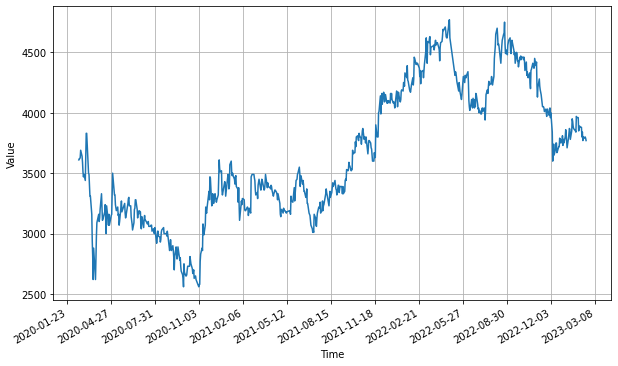

In [7]:
plot_series(df['Date'], df['Close'])

## Naive Forecast

Naive forecast's next value will be the same as the previous time step. Naive forecast is just steping 1 time behind actual curent value.
So we see that naive forecast lags 1 step behind the time series. Today's value well be predicted as yesterday value which of course will not be always the case 

In [8]:
# Define the split time
split_time = 100

naive_forecast = df['Close'][split_time - 1:-1]
x_valid = df['Close'][split_time:]

naive_forecast_wdate = df[split_time - 1:-1]
x_valid_wdate = df[split_time:]


# Define time step
time_step = 102

# Print values
print(f'ground truth at time step {time_step}: {x_valid[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step + 1]}')

ground truth at time step 102: 3060.0
prediction at time step 103: 3060.0


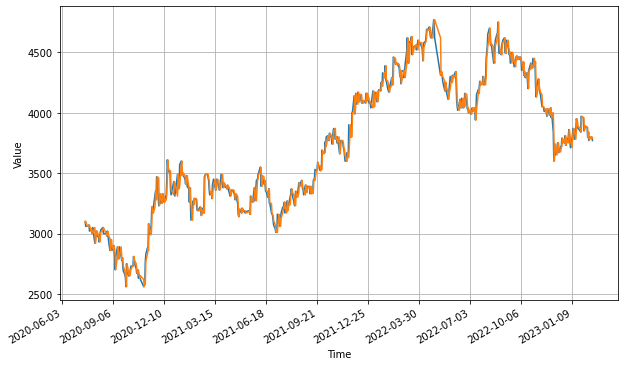

In [9]:
# Plot the results
plot_series(df['Date'][split_time:], (x_valid, naive_forecast))

In [10]:
naive_forecast_wdate[['Date', 'Close']]

,Date,Close
99,2020-07-15,3090.0
100,2020-07-16,3100.0
101,2020-07-17,3060.0
102,2020-07-20,3060.0
103,2020-07-21,3060.0
...,...,...
730,2023-02-09,3770.0
731,2023-02-10,3800.0
732,2023-02-13,3790.0
733,2023-02-14,3800.0


In [11]:
x_valid_wdate[['Date', 'Close']]

,Date,Close
100,2020-07-16,3100.0
101,2020-07-17,3060.0
102,2020-07-20,3060.0
103,2020-07-21,3060.0
104,2020-07-22,3070.0
...,...,...
731,2023-02-10,3800.0
732,2023-02-13,3790.0
733,2023-02-14,3800.0
734,2023-02-15,3790.0


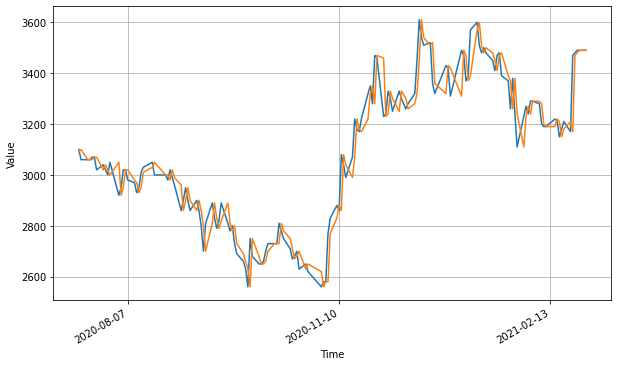

In [12]:
# Zooming in
plot_series(df['Date'][split_time:], (x_valid, naive_forecast), start=0, end=150)

### metrics

using *mean squared error* and *mean absolute error*

In [13]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

4436.477987421384
49.119496855345915


## Moving Average

 This sums up a series of time steps and the average will be the prediction for the next time step. For example, the average of the measurements at time steps 1 to 10 will be the forecast for time step 11, then the average for time steps 2 to 11 will be the forecast for time step 12, and so on.
 

In [14]:
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []
    
    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())
    
    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

(636,)
(636,)
(636,)


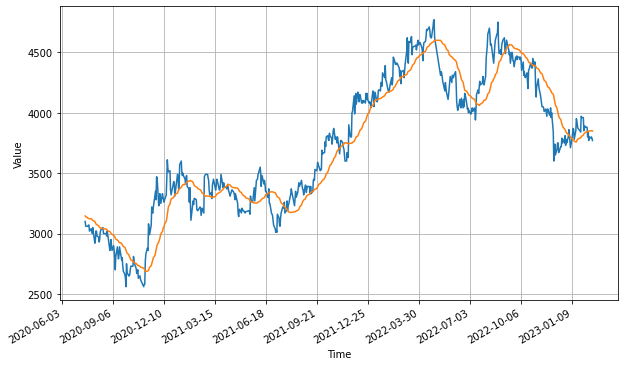

In [15]:
# Generate the moving average forecast
moving_avg = moving_average_forecast(df['Close'], 30)[split_time - 30:]
# Plot the results
print(moving_avg.shape)
print(x_valid.shape)
print(df['Date'][split_time:].shape)
plot_series(df['Date'][split_time:], (x_valid, moving_avg))

In [16]:
df['Date'][split_time - 30:].head()

70   2020-06-04
71   2020-06-05
72   2020-06-08
73   2020-06-09
74   2020-06-10
Name: Date, dtype: datetime64[ns]

In [17]:
df['Date'][split_time:]

100   2020-07-16
101   2020-07-17
102   2020-07-20
103   2020-07-21
104   2020-07-22
         ...    
731   2023-02-10
732   2023-02-13
733   2023-02-14
734   2023-02-15
735   2023-02-16
Name: Date, Length: 636, dtype: datetime64[ns]

In [18]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

31487.64028651293
143.13993710691827


worse than naive forecast! The moving average does not anticipate trend or seasonality. In particular, those huge spikes in the original series causes big deviations as shown in the plot above. You will try to remove these characteristics of the dataset with time differencing and see if you get better results.

## Differencing

Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*. That is done with the code below. 

In addition, we will need to align the result with the `time` array. Since you can only do time differencing for `t >= 365`, you will need to truncate the first 365 time steps of the `time` array.

You can plot the result to visualize the values.

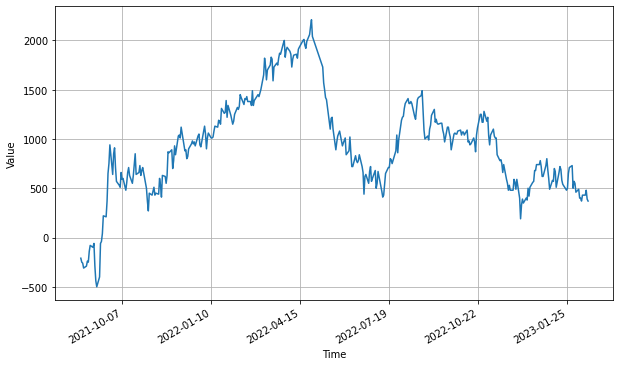

In [19]:
# Subtract the values at t-365 from original series
diff_series = (df['Close'][365:].values - df['Close'][:-365].values)

# Truncate the first 365 time steps
diff_time = df['Date'][365:]

# Plot the results
plot_series(diff_time, diff_series)

### using Moving Average on Differencing

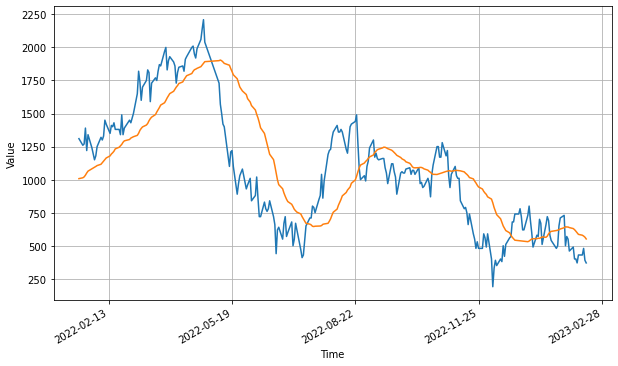

In [20]:

# Generate moving average from the time differenced dataset
diff_moving_avg0 = moving_average_forecast(diff_series, 30)

# Slice the prediction points that corresponds to the validation set time steps
diff_moving_avg1 = diff_moving_avg0[split_time - 365:]

# Slice the ground truth points that corresponds to the validation set time steps
diff_series1 = diff_series[split_time - 365:]

# Plot the results
plot_series(df['Date'][split_time - 365:], (diff_series1, diff_moving_avg1))

bring bring back the trend and seasonality by adding the past values from t – 365

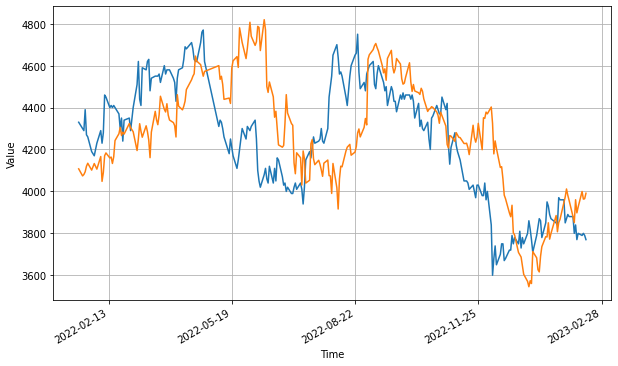

In [21]:
# Add the trend and seasonality from the original series
diff_moving_avg_plus_past = (df['Close'][:365])[split_time:] + diff_moving_avg1

# Plot the results
plot_series(df['Date'][split_time - 365:], (df['Close'][split_time - 365:], diff_moving_avg_plus_past))

In [22]:
print(tf.keras.metrics.mean_squared_error(df['Close'][split_time - 365:], diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(df['Close'][split_time - 365:], diff_moving_avg_plus_past).numpy())

69492.03731656182
210.9295597484277
